# Preprocessing and clustering 3k PBMCs

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html) ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)).

We gratefully acknowledge Seurat's authors for the tutorial! In the meanwhile, we have added and removed a few pieces.
    
The data consist in *3k PBMCs from a Healthy Donor* and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

In [2]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

<div class="alert alert-info">

**Note**
    
Download the notebook by clicking on the _Edit on GitHub_ button. On GitHub, you can download using the _Raw_ button via right-click and _Save Link As_. Alternatively, download the whole [scanpy-tutorial](https://github.com/theislab/scanpy-tutorials) repository.

</div>  

<div class="alert alert-info">

**Note**
    
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.

</div>

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc

In [5]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [6]:
results_file = 'saved/results/scanpyGDSC.h5ad'  # the file that will store the analysis results
select_drug = 'Cisplatin'

In [7]:
data_r=pd.read_csv('data/GDSC2_expression_cisplatin.csv',index_col=0)
label_r=pd.read_csv('data/GDSC2_label_cisplatin.csv',index_col=0)

In [12]:
isnot_NaN = data_r.isnull()
rows_not_NaN = ~isnot_NaN.any(axis=1)
data = data_r.loc[rows_not_NaN]
label = label_r.loc[rows_not_NaN.values]
label = label.iloc[:,2]

In [13]:
adata = sc.AnnData(data)

Read in the count matrix into an [`AnnData`](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5 file format: `.h5ad`.

In [14]:
# adata = sc.read_10x_mtx(
#     'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
#     var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
#     cache=True)                              # write a cache file for faster subsequent reading

#adata = sc.read_csv('data/GDSCexpression.csv')

In [15]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [16]:
adata.obs_names_make_unique()

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing counts per cell
    finished (0:00:00)


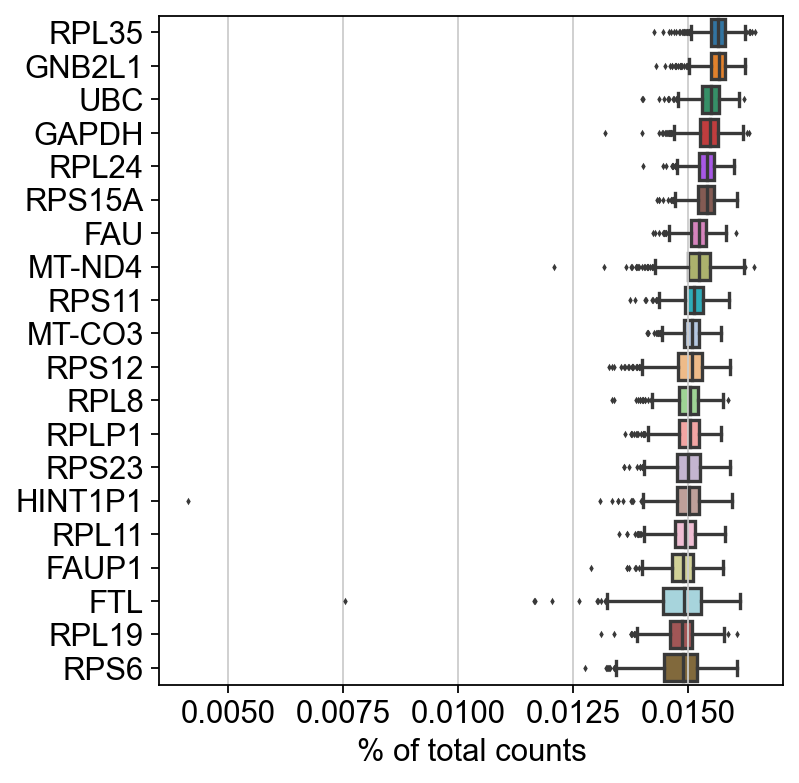

In [17]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering.

In [9]:
#sc.pp.filter_cells(adata, min_genes=200)
#sc.pp.filter_genes(adata, min_cells=3)

Let us assemple some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [18]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

A violin plot of some of the computed quality measures:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

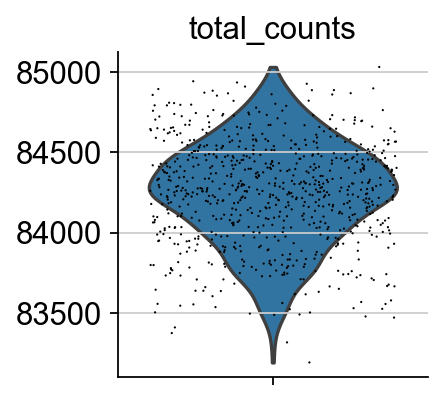

In [19]:
sc.pl.violin(adata, ['total_counts'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

Actually do the filtering by slicing the `AnnData` object.

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [20]:
sc.pp.normalize_total(adata, target_sum=75000)

normalizing counts per cell
    finished (0:00:00)


Logarithmize the data.

In [21]:
sc.pp.log1p(adata)

In [22]:
adata.X

array([[2.1516092, 1.1972038, 2.324683 , ..., 1.266602 , 2.1754277,
        1.3541646],
       [2.045223 , 1.2523067, 2.3223941, ..., 1.2946507, 2.2312095,
        1.351483 ],
       [2.1951132, 1.2848171, 2.2275298, ..., 1.2928953, 2.2539763,
        1.3945904],
       ...,
       [2.1830277, 1.2418938, 2.3617578, ..., 1.3324946, 2.2692316,
        1.347672 ],
       [2.098186 , 1.2942784, 2.2592716, ..., 1.243348 , 2.2202122,
        1.3547171],
       [2.1032445, 1.2461073, 2.2964597, ..., 1.4089918, 2.1826515,
        1.3347849]], dtype=float32)

Identify highly-variable genes.

In [23]:
sc.pp.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


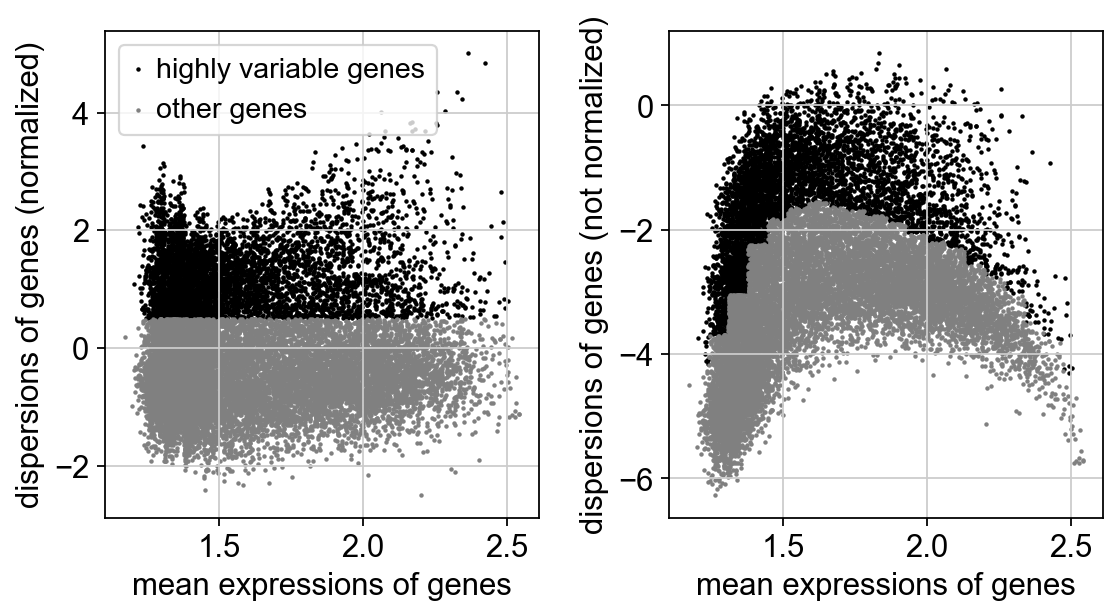

In [24]:
sc.pl.highly_variable_genes(adata,save="GDSC")

Set the `.raw` attribute of AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

<div class="alert alert-info">

**Note**

You can get back an `AnnData` of the object in `.raw` by calling `.raw.to_adata()`.

</div>    

In [25]:
adata.raw = adata

<div class="alert alert-info">

**Note**
    
If you don't proceed below with correcting the data with `sc.pp.regress_out` and scaling it via `sc.pp.scale`, you can also get away without using `.raw` at all.

The result of the previous highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step *actually do the filtering* below is unnecessary, too.

</div>

Actually do the filtering

In [26]:
adata = adata[:, adata.var.highly_variable]

In [27]:
sum(adata.var.highly_variable == True)

5108

In [28]:
adata.obs_names

Index(['DATA.749709', 'DATA.749710', 'DATA.749711', 'DATA.749712',
       'DATA.749713', 'DATA.749714', 'DATA.749715', 'DATA.749716',
       'DATA.749717', 'DATA.905945',
       ...
       'DATA.1524416', 'DATA.1659818', 'DATA.1659928', 'DATA.1660034',
       'DATA.1674021', 'DATA.688006', 'DATA.688010', 'DATA.924250',
       'DATA.949166', 'DATA.1660035'],
      dtype='object', length=765)

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [29]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:09)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [30]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [31]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

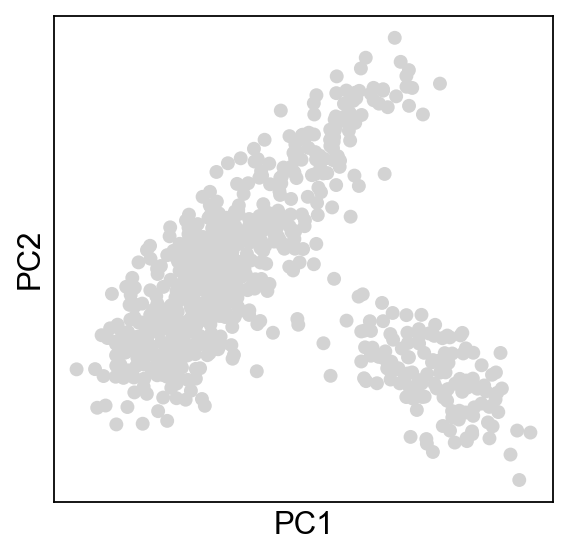

In [32]:
sc.pl.pca(adata,save="GDSC")

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

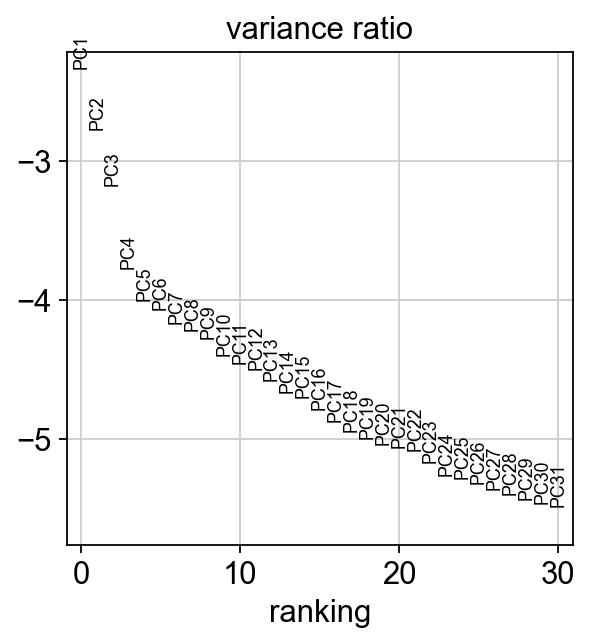

In [33]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [35]:
adata.write(results_file)

In [36]:
adata

AnnData object with n_obs × n_vars = 765 × 5108
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [37]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=16)

computing neighbors
    using 'X_pca' with n_pcs = 16
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


## Embedding the neighborhood graph

We advertise embedding the graph in 2 dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is  potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preservers trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [38]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


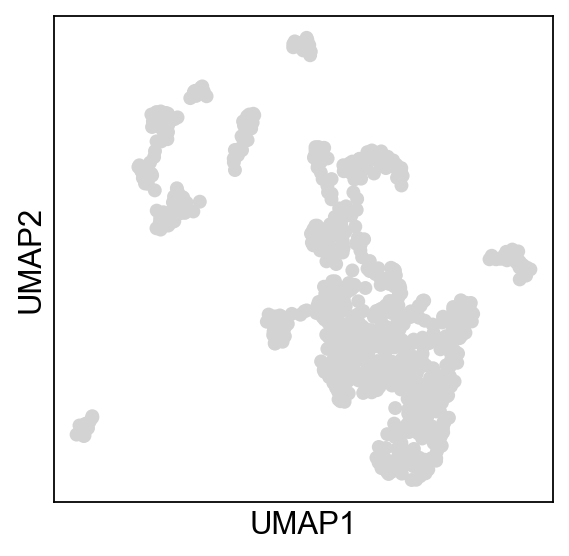

In [39]:
sc.pl.umap(adata)

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

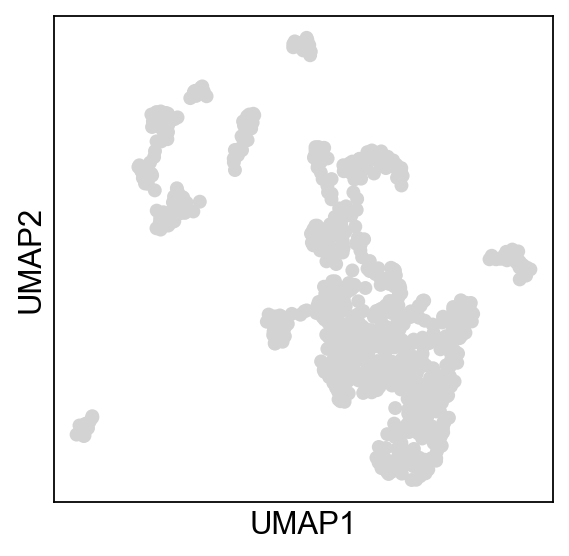

In [40]:
sc.pl.umap(adata, use_raw=False)

## Clustering the neighborhood graph

As Seurat and many others, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [41]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

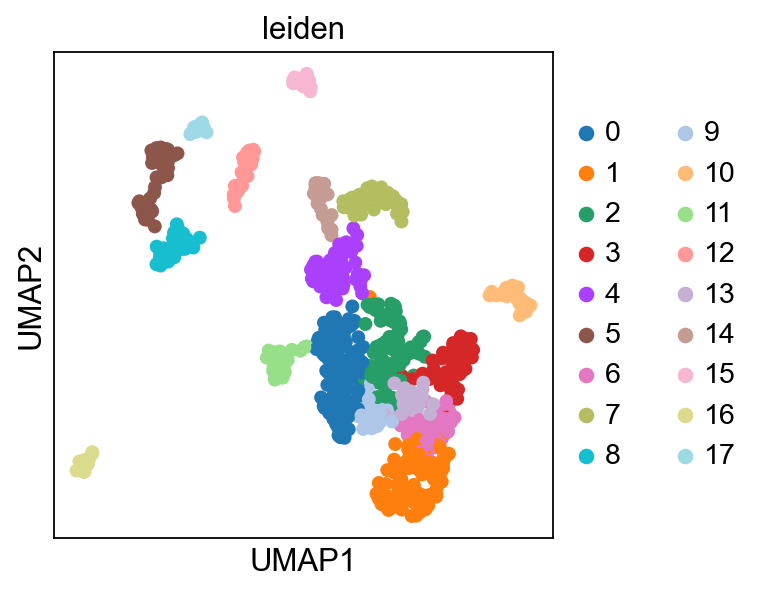

In [42]:
sc.pl.umap(adata, color=['leiden'],save="GDSC")

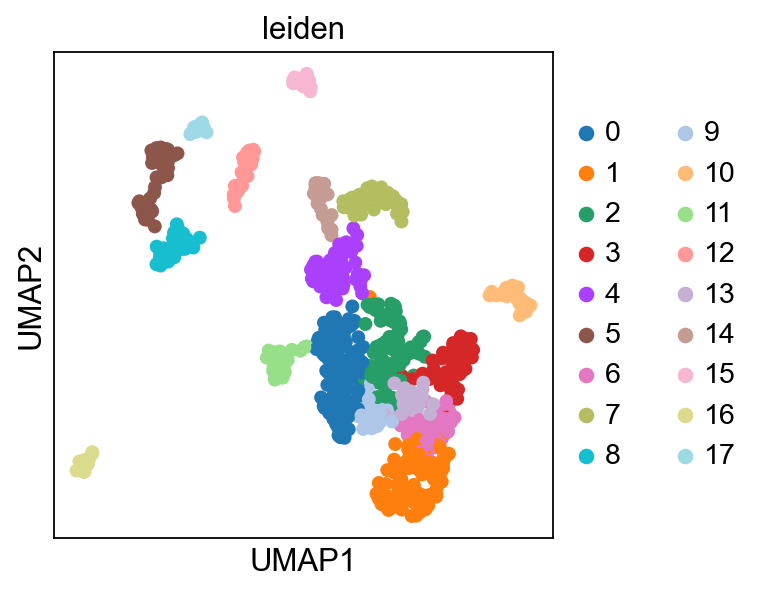

In [44]:
sc.pl.umap(adata, color=['leiden'],save="GDSC")

Save the result.

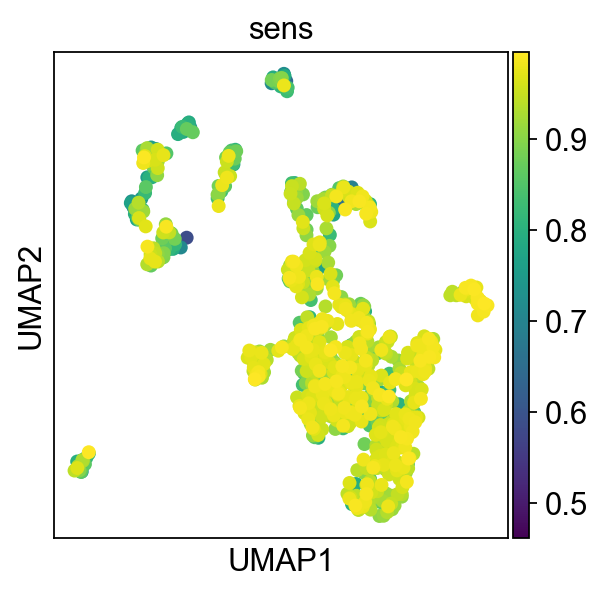

In [46]:
sens_result = adata.obs["leiden"]

sens_result = label

sens_result.index = adata.obs["leiden"].index

adata.obs["sens"] = sens_result

sc.pl.umap(adata, color=['sens'],save="GDSCsens")

In [47]:
adata.write(results_file)

In [48]:
sc.tl.umap(adata, n_components=256)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


## Regression 

In [39]:
#label =label.fillna(0)

In [50]:
selected_idx = label!=0

In [51]:
data = adata.obsm["X_umap"]

In [54]:
X = data[selected_idx]
y = label.loc[selected_idx]

from sklearn import preprocessing
scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
X = scaler.fit_transform(X)

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=16)

In [56]:
X_train

array([[ 0.39424106,  0.24462633,  0.8059498 , ..., -0.31760824,
        -0.43409652,  0.18740945],
       [ 0.5556092 ,  0.40199673, -0.2689456 , ..., -0.35921824,
        -0.19767386,  0.10052759],
       [-2.0368764 , -1.8275965 , -0.19126196, ...,  1.4020138 ,
         1.64263   , -0.347485  ],
       ...,
       [ 0.366218  ,  0.42629328, -0.72873634, ...,  0.06334675,
        -0.29582682, -1.2124982 ],
       [-2.647278  , -2.8218622 ,  0.10459439, ...,  3.4471257 ,
         3.1387055 ,  1.1952503 ],
       [ 0.7693294 ,  0.73222053, -1.1547297 , ...,  0.32310838,
         0.172901  , -1.59313   ]], dtype=float32)

In [57]:
y

DATA.749709     0.991170
DATA.749710     0.988846
DATA.749711     0.979764
DATA.749712     0.935861
DATA.749713     0.902275
                  ...   
DATA.688006     0.863384
DATA.688010     0.852685
DATA.924250     0.962938
DATA.949166     0.807983
DATA.1660035    0.982650
Name: AUC, Length: 765, dtype: float64

In [58]:
from sklearn.ensemble import AdaBoostRegressor
regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(X_train, Y_train.values)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=100, random_state=0)

In [59]:
adaboost = regr.predict(X_test)

In [60]:
from sklearn.metrics import r2_score

r2_score(adaboost,Y_test)

-12.472212367518086

In [63]:
adaboost

array([0.89457922, 0.85901651, 0.92678786, 0.88789231, 0.90501367,
       0.90203397, 0.90487508, 0.89125767, 0.88789231, 0.89125767,
       0.89125767, 0.90203397, 0.81913528, 0.88789231, 0.89457922,
       0.87517033, 0.90203397, 0.84676136, 0.89133425, 0.88789231,
       0.88789231, 0.90862372, 0.83773222, 0.89602571, 0.90227123,
       0.91650997, 0.90487508, 0.89457922, 0.88412197, 0.85302574,
       0.90313903, 0.89133425, 0.91991546, 0.87138721, 0.91846566,
       0.88438664, 0.90227123, 0.85724752, 0.89457922, 0.88146567,
       0.89676625, 0.92739125, 0.88432986, 0.92678786, 0.91735784,
       0.92366903, 0.86170408, 0.87138721, 0.90227123, 0.88154199,
       0.85901651, 0.89457922, 0.91650997, 0.89457922, 0.87648239,
       0.87648239, 0.92589554, 0.92366903, 0.88569719, 0.89457922,
       0.88412197, 0.90313903, 0.88432986, 0.92042662, 0.89602571,
       0.84472162, 0.89602571, 0.88789231, 0.89125767, 0.89602571,
       0.90862372, 0.90203397, 0.87675968, 0.86173066, 0.87227

In [49]:
X_train

array([[-1.1336299 ,  1.9942836 , -0.73512787, ..., -0.14640582,
        -0.00978492,  3.4292226 ],
       [ 0.51079464,  0.0576308 , -0.10611167, ...,  0.16857213,
        -0.2604934 , -0.34443566],
       [ 0.01394614,  0.8299418 ,  0.5345925 , ..., -0.02815866,
        -0.04525487, -0.02789601],
       ...,
       [-1.3107848 ,  2.021897  , -1.6813917 , ...,  2.0826778 ,
        -1.4340904 , -0.35525173],
       [ 1.1205318 , -0.5749836 , -2.548238  , ...,  0.14251424,
        -0.3233803 ,  0.14403087],
       [ 0.13159782, -0.13386887,  0.5282113 , ...,  0.06658085,
        -0.22951432,  0.08041935]], dtype=float32)

In [50]:
Y_test.sort_values()

MZ2-MEL    0.592194
NBsusSR    0.618787
GOTO       0.619828
ABC-1      0.642845
T-24       0.665118
             ...   
CA46       0.992609
SK-MM-2    0.994849
GAK        0.996788
OPM-2      0.997622
CAL-12T    0.998409
Name: Cisplatin, Length: 68, dtype: float64

In [51]:
y.loc["A375"]

0.594073449978018

In [52]:
y.sort_values()

NCI-H209         0.492905
ES3              0.504912
NTERA-S-cl-D1    0.573043
MIA-PaCa-2       0.585206
MZ2-MEL          0.592194
                   ...   
SBC-1            0.997699
OCUB-M           0.997927
CAL-12T          0.998409
RL               0.999327
NCI-H747         0.999466
Name: Cisplatin, Length: 671, dtype: float64

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


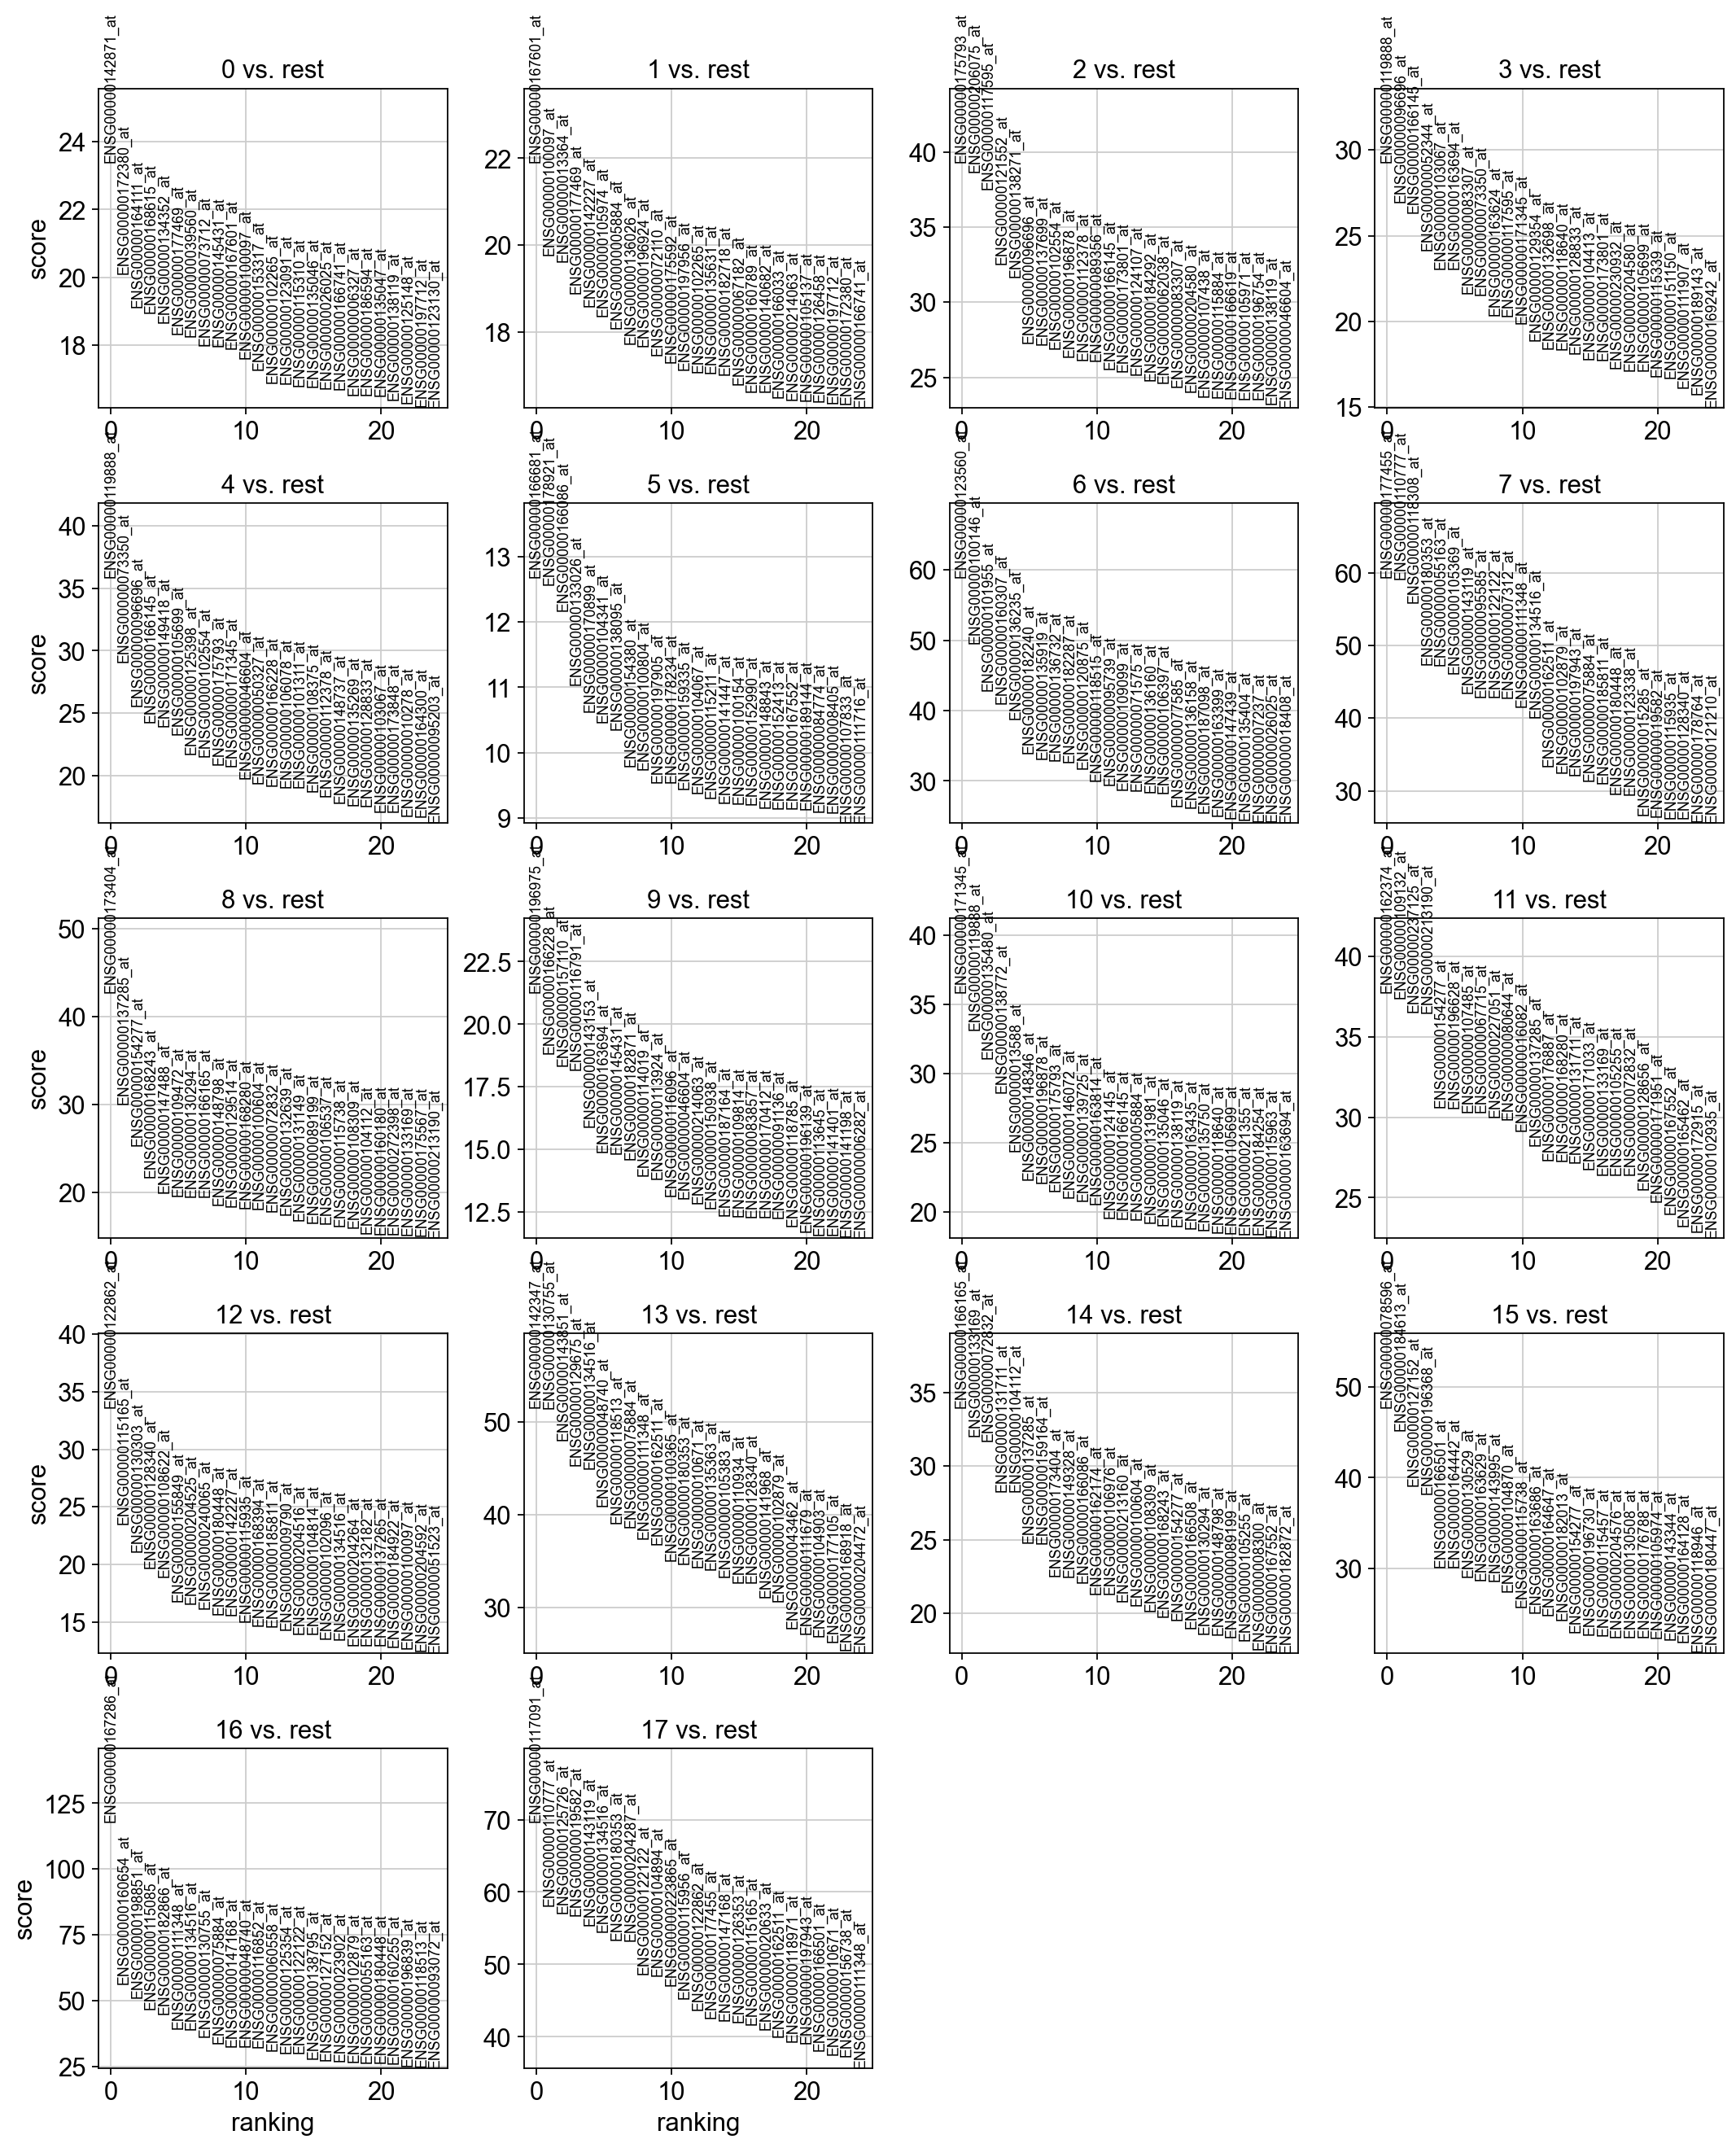

In [53]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,save="GDSCDEG")

In [54]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:01)


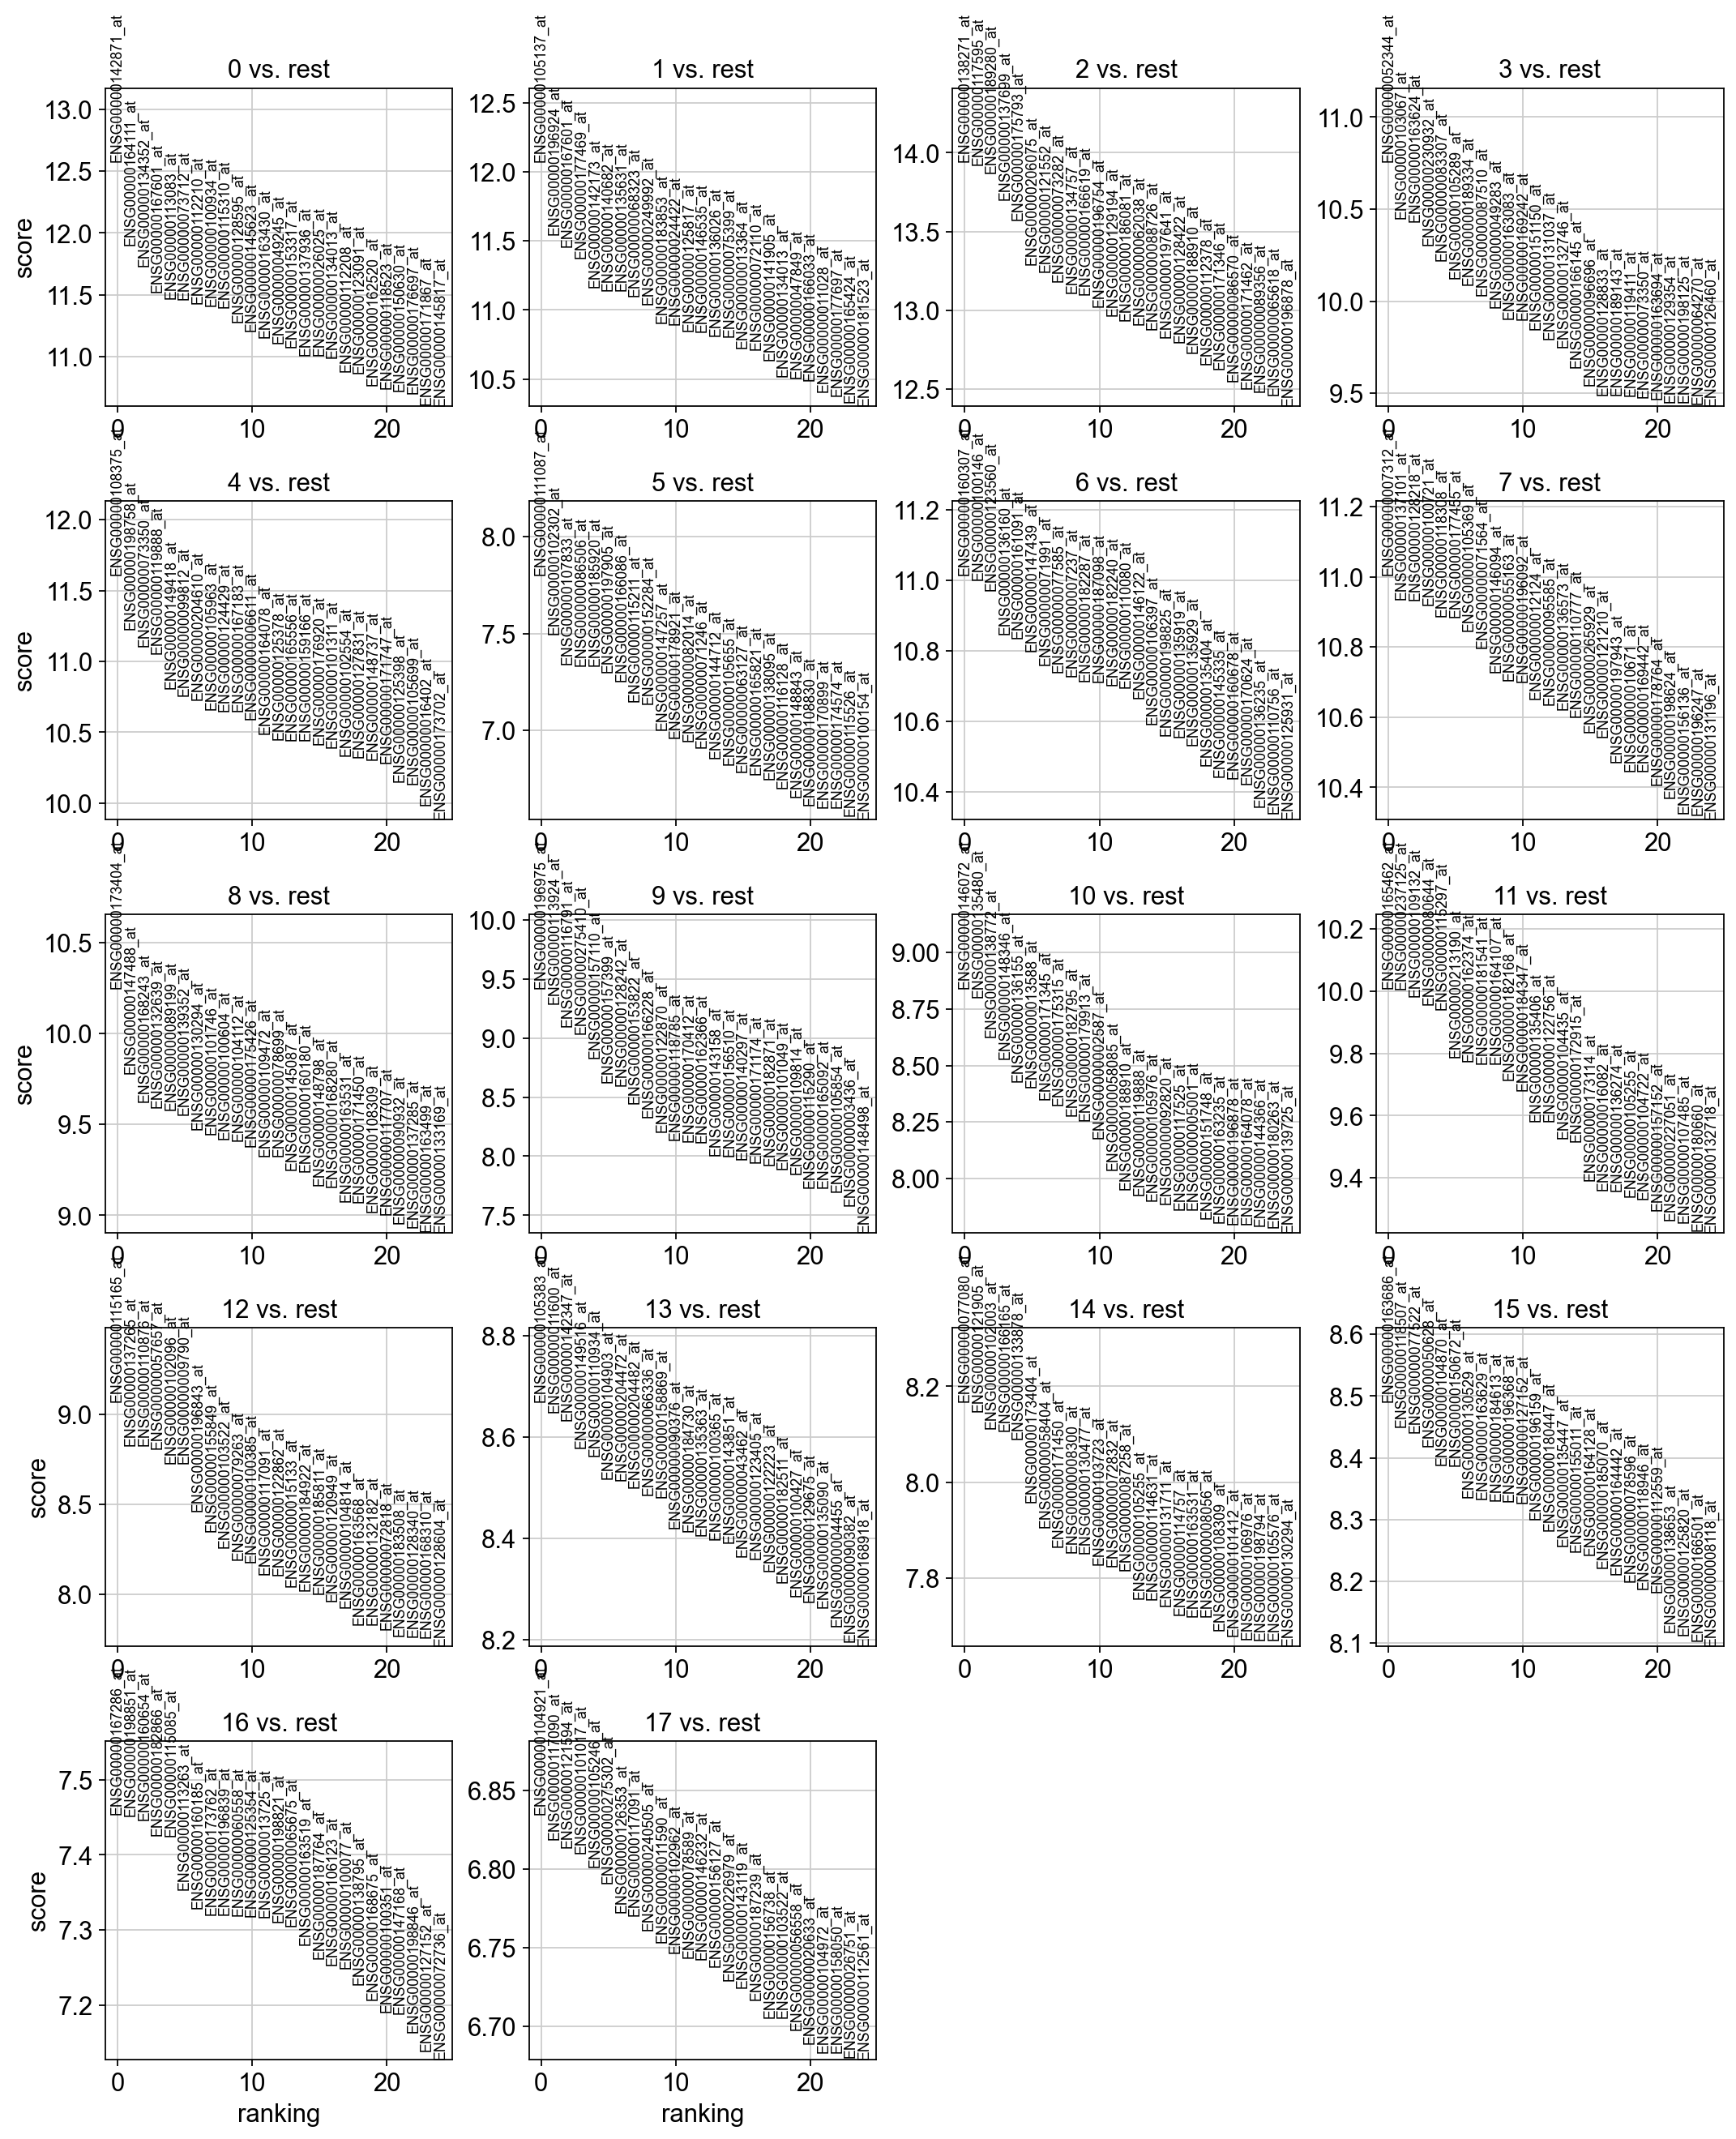

In [55]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [56]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

ranking genes
    finished (0:00:05)


D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


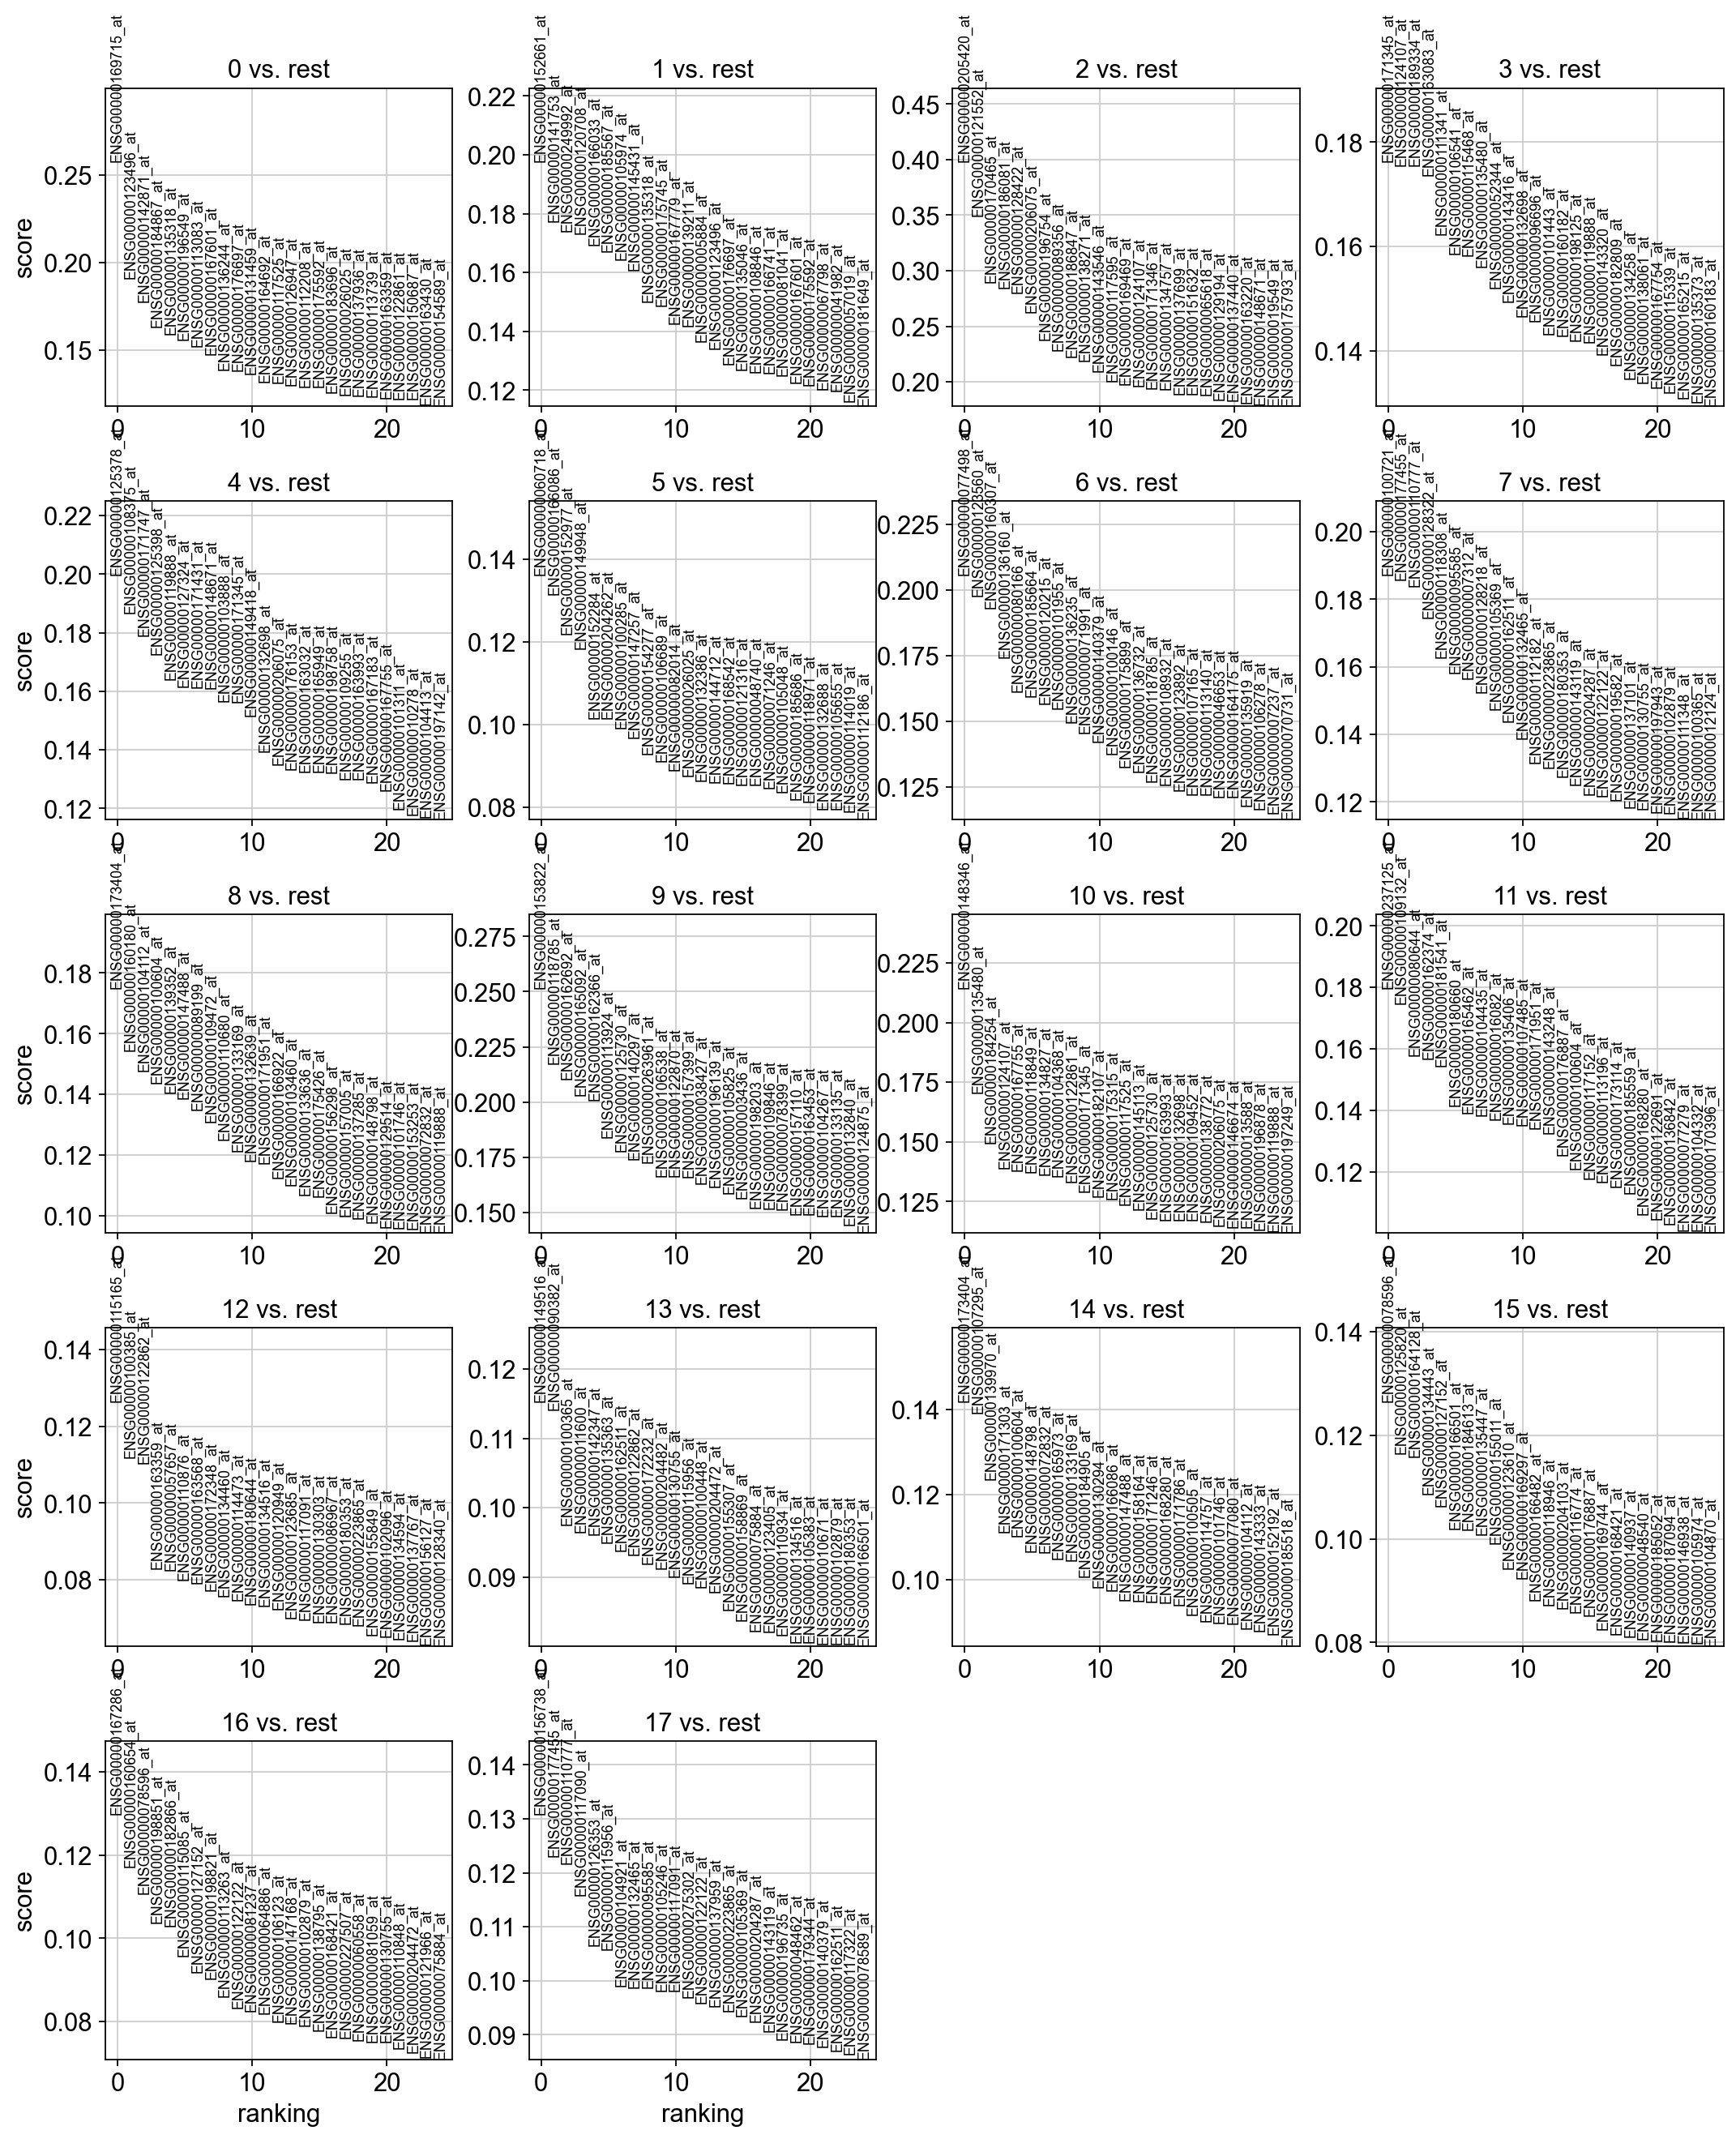

In [57]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Let us also define a list of marker genes for later reference.

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [58]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [59]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0                   1                   2  \
0  ENSG00000142871_at  ENSG00000105137_at  ENSG00000138271_at   
1  ENSG00000164111_at  ENSG00000196924_at  ENSG00000117595_at   
2  ENSG00000134352_at  ENSG00000167601_at  ENSG00000189280_at   
3  ENSG00000167601_at  ENSG00000177469_at  ENSG00000137699_at   
4  ENSG00000113083_at  ENSG00000142173_at  ENSG00000175793_at   

                    3                   4                   5  \
0  ENSG00000052344_at  ENSG00000108375_at  ENSG00000111087_at   
1  ENSG00000103067_at  ENSG00000198758_at  ENSG00000102302_at   
2  ENSG00000163624_at  ENSG00000073350_at  ENSG00000107833_at   
3  ENSG00000230932_at  ENSG00000119888_at  ENSG00000086506_at   
4  ENSG00000083307_at  ENSG00000149418_at  ENSG00000185920_at   

                    6                   7                   8  \
0  ENSG00000160307_at  ENSG00000007312_at  ENSG00000173404_at   
1  ENSG00000100146_at  ENSG00000137101_at  ENSG00000147488_at   
2  ENSG00000123560_at  ENSG00000128218_at  ENSG00000168243_at   
3  ENSG00000136160_at  ENSG00000100721_at  ENSG00000132639_at   
4  ENSG00000161091_at  ENSG00000118308_at  ENSG00000089199_at   

                    9                  10                  11  \
0  ENSG00000196975_at  ENSG00000146072_at  ENSG00000165462_at   
1  ENSG00000113924_at  ENSG00000135480_at  ENSG00000237125_at   
2  ENSG00000116791_at  ENSG00000138772_at  ENSG00000109132_at   
3  ENSG00000275410_at  ENSG00000148346_at  ENSG00000080644_at   
4  ENSG00000157110_at  ENSG00000136155_at  ENSG00000115297_at   

                   12                  13                  14  \
0  ENSG00000115165_at  ENSG00000105383_at  ENSG00000077080_at   
1  ENSG00000137265_at  ENSG00000011600_at  ENSG00000121905_at   
2  ENSG00000110876_at  ENSG00000142347_at  ENSG00000102003_at   
3  ENSG00000057657_at  ENSG00000149516_at  ENSG00000166165_at   
4  ENSG00000102096_at  ENSG00000110934_at  ENSG00000133878_at   

                   15                  16                  17  
0  ENSG00000163686_at  ENSG00000167286_at  ENSG00000104921_at  
1  ENSG00000118507_at  ENSG00000198851_at  ENSG00000117090_at  
2  ENSG00000077522_at  ENSG00000160654_at  ENSG00000121594_at  
3  ENSG00000050628_at  ENSG00000182866_at  ENSG00000101017_at  
4  ENSG00000104870_at  ENSG00000115085_at  ENSG00000105246_at

Get a table with the scores and groups.

In [60]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n           0_p                 1_n           1_p  \
0  ENSG00000142871_at  2.731448e-36  ENSG00000105137_at  1.407002e-33   
1  ENSG00000164111_at  1.190052e-32  ENSG00000196924_at  7.703932e-31   
2  ENSG00000134352_at  8.645212e-32  ENSG00000167601_at  2.098322e-30   
3  ENSG00000167601_at  1.067066e-30  ENSG00000177469_at  5.411450e-30   
4  ENSG00000113083_at  1.933741e-30  ENSG00000142173_at  6.016193e-29   

                  2_n           2_p                 3_n           3_p  \
0  ENSG00000138271_at  3.371422e-44  ENSG00000052344_at  5.347667e-27   
1  ENSG00000117595_at  4.714152e-44  ENSG00000103067_at  1.473035e-25   
2  ENSG00000189280_at  9.134614e-44  ENSG00000163624_at  1.763615e-25   
3  ENSG00000137699_at  9.942215e-43  ENSG00000230932_at  6.559187e-25   
4  ENSG00000175793_at  5.916459e-42  ENSG00000083307_at  1.580016e-24   

                  4_n           4_p  ...                13_n          13_p  \
0  ENSG00000108375_at  3.557413e-31  ...  ENSG00000105383_at  4.291856e-18   
1  ENSG00000198758_at  3.083951e-29  ...  ENSG00000011600_at  5.160109e-18   
2  ENSG00000073350_at  1.162576e-28  ...  ENSG00000142347_at  5.923045e-18   
3  ENSG00000119888_at  1.998226e-28  ...  ENSG00000149516_at  9.651880e-18   
4  ENSG00000149418_at  3.130261e-27  ...  ENSG00000110934_at  1.098288e-17   

                 14_n          14_p                15_n          15_p  \
0  ENSG00000077080_at  3.115884e-16  ENSG00000163686_at  2.038443e-17   
1  ENSG00000121905_at  3.719795e-16  ENSG00000118507_at  2.899110e-17   
2  ENSG00000102003_at  4.992436e-16  ENSG00000077522_at  3.129124e-17   
3  ENSG00000166165_at  5.217165e-16  ENSG00000050628_at  3.814821e-17   
4  ENSG00000133878_at  5.952880e-16  ENSG00000104870_at  4.901865e-17   

                 16_n          16_p                17_n          17_p  
0  ENSG00000167286_at  9.078972e-14  ENSG00000104921_at  8.234087e-12  
1  ENSG00000198851_at  9.220352e-14  ENSG00000117090_at  9.174090e-12  
2  ENSG00000160654_at  9.583336e-14  ENSG00000121594_at  9.534659e-12  
3  ENSG00000182866_at  1.118105e-13  ENSG00000101017_at  9.757626e-12  
4  ENSG00000115085_at  1.126747e-13  ENSG00000105246_at  1.037748e-11  

[5 rows x 36 columns]

Compare to a single cluster. 

ranking genes
    finished (0:00:00)


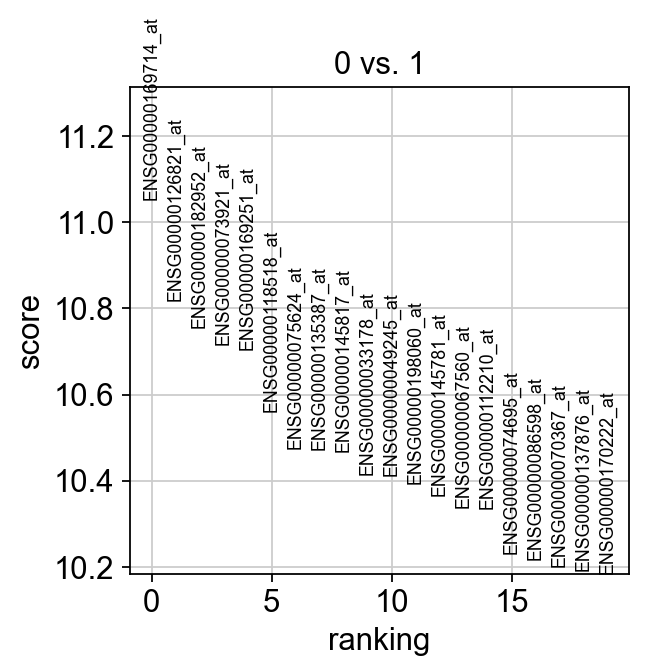

In [61]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)